In [6]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1) (1).zip


In [3]:
photoooo = input("Enter the full path to your file: ")


Enter the full path to your file: happy test.jpg


In [7]:
# Unzip the uploaded file
import zipfile, os, shutil

zip_path = "/content/archive (1).zip"
extract_path = "/content/fer2013"

# Clean previous extraction
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Unzipped to: {extract_path}")
print("Top-level contents:", os.listdir(extract_path))

#  Locate folder containing 'train' and 'test'

data_root = extract_path

if not os.path.exists(os.path.join(data_root, 'train')) or not os.path.exists(os.path.join(data_root, 'test')):
     raise Exception(" Could not find 'train' or 'test' folders in the unzipped data.")


print(f" Found data root: {data_root}")

#  Emotion label mapping
emotion_label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "sad": 4,
    "surprise": 5,
    "neutral": 6
}

#  Image processing
import pandas as pd
import numpy as np
from PIL import Image

usage_folders = {
    'Training': 'train',
    'Test': 'test'
}

data = []

for usage_label, folder_name in usage_folders.items():
    folder_path = os.path.join(data_root, folder_name)

    if not os.path.exists(folder_path):
        print(f" Missing folder: {folder_path}")
        continue

    for emotion_folder in os.listdir(folder_path):
        emotion_path = os.path.join(folder_path, emotion_folder)
        if not os.path.isdir(emotion_path):
            continue

        label = emotion_label_map.get(emotion_folder.lower())
        if label is None:
            print(f" Unknown label: {emotion_folder}")
            continue

        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            try:
                img = Image.open(img_path).convert('L').resize((48, 48))
                pixels = np.array(img).flatten()
                pixel_str = ' '.join(str(p) for p in pixels)

                data.append({
                    'emotion': label,
                    'pixels': pixel_str,
                    'Usage': usage_label
                })
            except Exception as e:
                print(f" Error reading {img_path}: {e}")

# Save as CSV
df = pd.DataFrame(data)
csv_path = "/content/fer2013_converted.csv"
df.to_csv(csv_path, index=False)

print(f"\n CSV saved at: {csv_path}")
print(f" Number of records: {len(df)}")
display(df.head())

Unzipped to: /content/fer2013
Top-level contents: ['test', 'train']
 Found data root: /content/fer2013

 CSV saved at: /content/fer2013_converted.csv
 Number of records: 35887


,emotion,pixels,Usage
0,1,13 15 21 28 33 33 39 56 78 47 43 52 72 71 56 1...,Training
1,1,244 199 156 149 148 144 113 102 70 88 174 198 ...,Training
2,1,221 229 226 229 229 232 231 235 232 240 214 11...,Training
3,1,152 157 159 163 169 191 203 202 206 169 44 22 ...,Training
4,1,20 22 18 20 32 41 50 63 69 77 82 85 91 96 102 ...,Training


Data loaded: (35887, 3)
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64
Image shape: (35887, 48, 48, 1)
Label shape: (35887, 7)
Resized shape for VGG16: (28709, 48, 48, 3)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.2177 - loss: 1.9230 - val_accuracy: 0.3385 - val_loss: 1.6730
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.3172 - loss: 1.7073 - val_accuracy: 0.3566 - val_loss: 1.6321
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.3324 - loss: 1.6683 - val_accuracy: 0.3753 - val_loss: 1.6064
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.3617 - loss: 1.6309 - val_accuracy: 0.3813 - val_loss: 1.5915
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3664 - loss: 1.6152 - val_accuracy: 0.3873 - val_loss: 1.5774
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.378

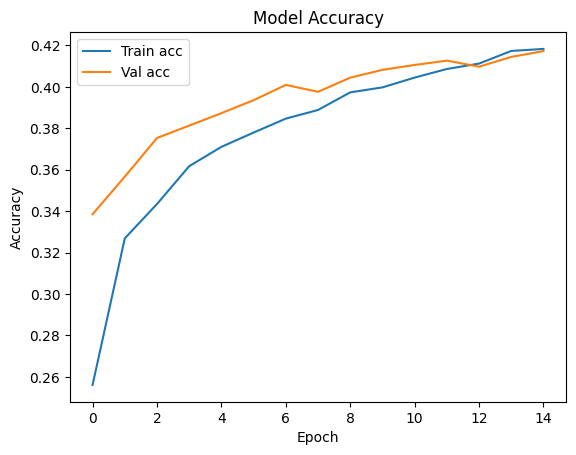

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load the converted CSV
csv_path = '/content/fer2013_converted.csv'
df = pd.read_csv(csv_path)
print("Data loaded:", df.shape)
print(df['emotion'].value_counts())

# 2. Convert pixel string to image arrays
def process_pixels(pixel_str):
    pixels = np.array(pixel_str.split(), dtype='float32')
    return pixels.reshape(48, 48, 1) / 255.0

X = np.array([process_pixels(pix) for pix in df['pixels']])
y = to_categorical(df['emotion'], num_classes=7)
print("Image shape:", X.shape)
print("Label shape:", y.shape)

# 3. Split into train/test/val
train_idx = df['Usage'] == 'Training'
val_idx = df['Usage'] == 'Test'  # public/private test both can be used

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[val_idx], y[val_idx]

# 4. Resize to 48x48x3 to fit into VGG16 (which expects 3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)
print("Resized shape for VGG16:", X_train_rgb.shape)

# 5. Load VGG16 without top layer
base_model = VGG16(include_top=False, input_shape=(48, 48, 3), weights='imagenet')

# Freeze VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# 6. Add custom classifier on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 7. Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 8. Train
history = model.fit(X_train_rgb, y_train,
                    validation_data=(X_test_rgb, y_test),
                    epochs=15,
                    batch_size=64)

# 9. Evaluate
test_loss, test_acc = model.evaluate(X_test_rgb, y_test)
print(f"\n Test accuracy: {test_acc:.4f}")

# 10. Plot training history
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [10]:
from PIL import Image
import numpy as np

def predict_emotion(image_path):
    img = Image.open(image_path).convert('L').resize((48, 48))
    img = np.stack((img,)*3, axis=-1)  # Convert grayscale to 3-channel
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_label = emotion_labels[np.argmax(predictions)]

    return predicted_label, predictions[0]

# Example usage:
result, probs = predict_emotion(photoooo)
print("Predicted Emotion:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion: Neutral


In [13]:
from google.colab import files
uploaded = files.upload()

Saving music rec dataset.zip to music rec dataset.zip


 Unzipped contents: ['data_by_genres.csv']
 CSV Loaded: /content/music_dataset/data_by_genres.csv
   mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1                      []      0.651417      0.529093  2.328809e+05   
4     1              a cappella      0.676557      0.538961  1.906285e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.419146          0.205309  0.218696 -12.288965     0.107872  112.857352   
4  0.316434          0.003003  0.172254 -12.

/tmp/ipython-input-14-3331570132.py:80: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


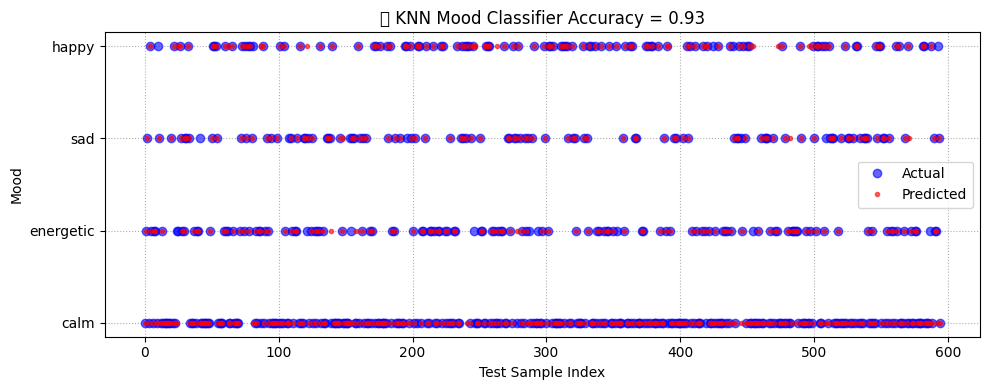


 Facial Expression Detected: Neutral
 Recommending a CALM playlist...

Top 5 Songs from Playlist:
     song
1  calm 1
3  calm 2
4  calm 3
5  calm 4
6  calm 5

 Total songs in 'calm' playlist: 1335


In [14]:
#  Unzip the uploaded ZIP
import zipfile
import os

zip_path = "/content/music rec dataset.zip"
extract_to = "/content/music_dataset"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" Unzipped contents:", os.listdir(extract_to))

# STEP 2: Load CSV from extracted folder
import pandas as pd

csv_files = [f for f in os.listdir(extract_to) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in extracted folder.")

csv_path = os.path.join(extract_to, csv_files[0])
df = pd.read_csv(csv_path)
print(" CSV Loaded:", csv_path)
print(df.head())

# STEP 3: Clean and classify mood based on acoustic features
features = ['acousticness', 'danceability', 'energy', 'valence']
df = df.dropna(subset=features).copy()

def classify_mood(row):
    if row['valence'] > 0.6 and row['energy'] > 0.6:
        return 'happy'
    elif row['valence'] < 0.4 and row['acousticness'] > 0.5:
        return 'sad'
    elif row['energy'] > 0.7:
        return 'energetic'
    else:
        return 'calm'

df['mood'] = df.apply(classify_mood, axis=1)
print("Mood classification complete")
print(df['mood'].value_counts())

# STEP 4: Replace song names with mood-based labels
df['song'] = None
for mood in df['mood'].unique():
    mood_indices = df[df['mood'] == mood].index
    for i, idx in enumerate(mood_indices, 1):
        df.at[idx, 'song'] = f"{mood} {i}"

# STEP 5: Save preprocessed file (optional)
df.to_csv("/content/preprocessed_music_dataset.csv", index=False)

# STEP 6: KNN model to classify moods
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X = df[features]
y = df['mood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# STEP 7: Accuracy plot with dotted line
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), list(y_test), 'bo', label='Actual', alpha=0.6)
plt.plot(range(len(y_pred)), list(y_pred), 'r.', label='Predicted', alpha=0.6)
plt.title(f'🎵 KNN Mood Classifier Accuracy = {accuracy:.2f}')
plt.xlabel("Test Sample Index")
plt.ylabel("Mood")
plt.grid(True, linestyle='dotted')
plt.legend()
plt.tight_layout()
plt.show()

#  Simulate facial emotion output
facial_emotion_output = result

# Emotion-to-playlist mapping
mood_map = {
    'neutral': 'calm',
    'angry': 'calm',
    'fear': 'calm',
    'disgust': 'calm',
    'surprise': 'energetic',
    'sad': 'sad',
    'happy': 'happy'
}

recommended_mood = mood_map.get(facial_emotion_output, 'calm')
print(f"\n Facial Expression Detected: {facial_emotion_output}")
print(f" Recommending a {recommended_mood.upper()} playlist...\n")

# STEP 9: Show playlist with renamed songs
playlist = df[df['mood'] == recommended_mood]

print("Top 5 Songs from Playlist:")
print(playlist[['song']].head(5))  # display renamed song column
print(f"\n Total songs in '{recommended_mood}' playlist: {len(playlist)}")